# Oronto Group Age Depth Modeling

This notebook is for developing a Chron.jl age model for the Oronto Group

In [1]:
    using Chron
    using Plots
    using CSV
    using DataFrames
    using SubsidenceChron

using StatGeochem, Distributions, Plots, Statistics, StatsBase

In [49]:
nSamples = 4
# Make an instance of a Chron Section object for nSamples
smpl = NewChronAgeData(nSamples)
smpl.Name          = ("Sample 1", "Sample 2", "Sample 3","Sample 4") # Et cetera
smpl.Age          .= [   1085.6,   1078,    1052, 1050] # Measured ages
smpl.Age_sigma    .= [        0.65,       12,    0.85,5] # Measured 1-σ uncertainties
smpl.Height       .= [    -4330,    -3630,         -100,0] # Depths below surface should be negative
smpl.Height_sigma .= [     10,     100,          10,10] # Usually assume little or no sample height uncertainty
smpl.Age_Sidedness .= [       0,        0,           -1,1] # Sidedness (zeros by default: geochron constraints are two-sided). Use -1 for a maximum age and +1 for a minimum age, 0 for two-sided
smpl.Age_Unit = "Ma" # Unit of measurement for ages
smpl.Height_Unit = "m" # Unit of measurement for Height and Height_sigma
# IMPORTANT: smpl.Height must increase with increasing stratigraphic height
# -- i.e., stratigraphically younger samples must be more positive. For this
# reason, it is convenient to represent depths below surface as negative
# numbers.
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


"m"

In [2]:
nSamples = 4
# Make an instance of a Chron Section object for nSamples
smpl = NewChronAgeData(nSamples)
smpl.Name          = ("Sample 1", "Sample 2", "Sample 3","Sample 4") # Et cetera
smpl.Age          .= [   1085.6,   1078,    1052, 1050] # Measured ages
smpl.Age_sigma    .= [        0.65,       12,    0.85,5] # Measured 1-σ uncertainties
smpl.Height       .= [    1300,    1800,5800         ,6000] # Depths below surface should be negative
smpl.Height_sigma .= [     10,     100,          10,10] # Usually assume little or no sample height uncertainty
smpl.Age_Sidedness .= [       0,        0,           -1,1] # Sidedness (zeros by default: geochron constraints are two-sided). Use -1 for a maximum age and +1 for a minimum age, 0 for two-sided
smpl.Age_Unit = "Ma" # Unit of measurement for ages
smpl.Height_Unit = "m" # Unit of measurement for Height and Height_sigma
# IMPORTANT: smpl.Height must increase with increasing stratigraphic height
# -- i.e., stratigraphically younger samples must be more positive. For this
# reason, it is convenient to represent depths below surface as negative
# numbers.
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


"m"

In [14]:
config = StratAgeModelConfiguration()
# If you in doubt, you can probably leave these parameters as-is
config.resolution = 10 # Same units as sample height. Smaller is slower!
config.bounding = 0.5 # how far away do we place runaway bounds, as a fraction of total section height. Larger is slower.
(bottom, top) = extrema(smpl.Height)
npoints_approx = round(Int,length(bottom:config.resolution:top) * (1 + 2*config.bounding))
config.nsteps = 60000 # Number of steps to run in distribution MCMC
config.burnin = 40000*npoints_approx # Number to discard
config.sieve = round(Int,npoints_approx) # Record one out of every nsieve steps
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


942

In [15]:
@time (mdl, agedist, lldist) = StratMetropolis(smpl, config);

┌ Info: Generating stratigraphic age-depth model...
└ @ Chron /Users/anthonyfuentes/.julia/packages/Chron/ZJDLJ/src/StratMetropolis.jl:27
┌ Info: Burn-in: 37680000 steps
└ @ Chron /Users/anthonyfuentes/.julia/packages/Chron/ZJDLJ/src/StratMetropolis.jl:522
Burn-in... 100%|█████████████████████████████████████████| Time: 0:00:21
┌ Info: Collecting sieved stationary distribution: 56520000 steps
└ @ Chron /Users/anthonyfuentes/.julia/packages/Chron/ZJDLJ/src/StratMetropolis.jl:593
Collecting... 100%|██████████████████████████████████████| Time: 0:00:31


 54.942450 seconds (1.40 M allocations: 947.202 MiB, 0.17% gc time, 1.55% compilation time)


In [16]:
hdl = plot(framestyle=:box,
fg_color_legend=:white,
xlabel="Age ($(smpl.Age_Unit))",
ylabel="Height ($(smpl.Height_Unit))",
);

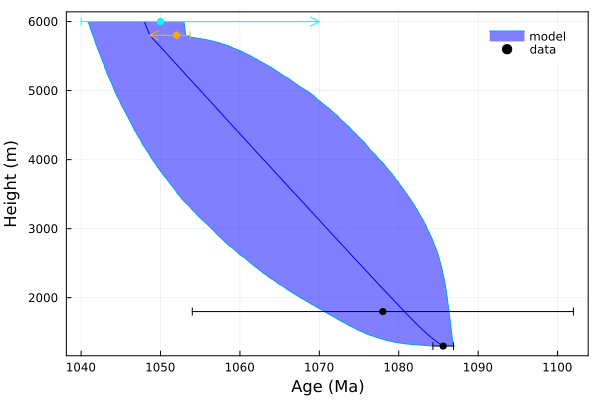

In [17]:
plot!(hdl, [mdl.Age_025CI; reverse(mdl.Age_975CI)],[mdl.Height; reverse(mdl.Height)], fill=(round(Int,minimum(mdl.Height)),0.5,:blue), label="model")
plot!(hdl, mdl.Age, mdl.Height, linecolor=:blue, label="") # Center line
t = smpl.Age_Sidedness .== 0 # Two-sided constraints (plot in black)
any(t) && plot!(hdl, smpl.Age[t], smpl.Height[t], xerror=2*smpl.Age_sigma[t],label="data",seriestype=:scatter,color=:black)
t = smpl.Age_Sidedness .== 1 # Minimum ages (plot in cyan)
any(t) && plot!(hdl, smpl.Age[t], smpl.Height[t], xerror=(2*smpl.Age_sigma[t],zeros(count(t))),label="",seriestype=:scatter,color=:cyan,msc=:cyan)
any(t) && zip(smpl.Age[t], smpl.Age[t].+nanmean(smpl.Age_sigma[t])*4, smpl.Height[t]) .|> x-> plot!([x[1],x[2]],[x[3],x[3]], arrow=true, label="", color=:cyan)
t = smpl.Age_Sidedness .== -1 # Maximum ages (plot in orange)
any(t) && plot!(hdl, smpl.Age[t], smpl.Height[t], xerror=(zeros(count(t)),2*smpl.Age_sigma[t]),label="",seriestype=:scatter,color=:orange,msc=:orange)
any(t) && zip(smpl.Age[t], smpl.Age[t].-nanmean(smpl.Age_sigma[t])*4, smpl.Height[t]) .|> x-> plot!([x[1],x[2]],[x[3],x[3]], arrow=true, label="", color=:orange)
#savefig(hdl,"AgeDepthModel.pdf")
display(hdl)

In [51]:
mdl_ages=DataFrame((height=mdl.Height,age=mdl.Age,low_ci=mdl.Age_025CI,up_ci=mdl.Age_975CI))
data_path=joinpath("/Users/anthonyfuentes/GitHub/Freda_Pmag/data/geochron/age_model.csv")
CSV.write(data_path,mdl_ages)

"/Users/anthonyfuentes/GitHub/Freda_Pmag/data/geochron/age_model.csv"

In [9]:
height = 2000
age_at_height = linterp1s(mdl.Height,mdl.Age,height)
age_at_height_min = linterp1s(mdl.Height,mdl.Age_025CI,height)
age_at_height_max = linterp1s(mdl.Height,mdl.Age_975CI,height)
print("Interpolated age at height=$height: $age_at_height +$(age_at_height_max-age_at_height)/-$(age_at_height-age_at_height_min) $(smpl.Age_Unit)")


Interpolated age at height=2000: 1079.0341006381823 +7.074340623195667/-11.484221341914918 Ma